In [1]:
# Imports

import os
import json
import joblib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.multioutput import MultiOutputRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error
import seaborn as sns
from matplotlib.font_manager import FontProperties

In [2]:
# Global Plot Settings

plt.rcParams.update({
    'figure.dpi': 200,
    'savefig.dpi': 300,
    'font.family': 'Avenir',
    'font.size': 10,
    'axes.labelsize': 10,
    'axes.titlesize': 11,
    'xtick.labelsize': 9,
    'ytick.labelsize': 9,
    'legend.fontsize': 9,
    'axes.grid': False
})

# === Global plot style with Avenir font ===
sns.set_style("white")  # Minimal grid
avenir_font = FontProperties(family='Avenir')
avenir_font_small = FontProperties(family='Avenir', size=7)

In [3]:
# Load Data & Metadata

df = pd.read_feather("../data/processed/cleaned_nhanes.feather")
with open("../data/processed/metadata.json") as f:
    meta = json.load(f)

target_cols = meta["target_cols"]
cat_features = meta["cat_features"]
num_features = meta["num_features"]

assert df[target_cols].notnull().all().all(), "❌ Unexpected NaNs in target columns!"

In [4]:
print(target_cols)

['triglycerides', 'hdl_cholesterol']


In [5]:
# Train/Test Split

X = df.drop(columns=target_cols)
y = df[target_cols]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

In [6]:
# Scale the target manually

# Initialize and fit scaler
target_scaler = StandardScaler()
y_train_scaled_array = target_scaler.fit_transform(y_train)
y_test_scaled_array = target_scaler.transform(y_test)

# Wrap back into DataFrames for column-based access
y_train_scaled = pd.DataFrame(y_train_scaled_array, columns=y_train.columns, index=y_train.index)
y_test_scaled = pd.DataFrame(y_test_scaled_array, columns=y_test.columns, index=y_test.index)

In [7]:
# Preprocessing Pipelines

numeric_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())
])

categorical_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('encoder', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])

preprocessor = ColumnTransformer([
    ('num', numeric_pipeline, num_features),
    ('cat', categorical_pipeline, cat_features)
])

In [8]:
# Train & Evaluate Random Forest (baseline #1)

rf_model = Pipeline([
    ('preprocessing', preprocessor),
    ('regressor', MultiOutputRegressor(RandomForestRegressor(random_state=42)))
])
rf_model.fit(X_train, y_train_scaled)
y_pred_rf = rf_model.predict(X_test)

print("\n=== Random Forest Performance ===")
rf_metrics = []
for i, col in enumerate(target_cols):
    r2 = r2_score(y_test_scaled[col], y_pred_rf[:, i])
    rmse = mean_squared_error(y_test_scaled[col], y_pred_rf[:, i], squared=False)
    rf_metrics.append((col, r2, rmse))
    print(f"{col:<20}  R²: {r2:.3f}    RMSE: {rmse:.3f}")


=== Random Forest Performance ===
triglycerides         R²: 0.078    RMSE: 1.041
hdl_cholesterol       R²: 0.219    RMSE: 0.981


In [9]:
# Train & Evaluate Multivariate Linear Regression (baseline #2)

linear_model = Pipeline([
    ('preprocessing', preprocessor),
    ('regressor', MultiOutputRegressor(LinearRegression()))
])
linear_model.fit(X_train, y_train_scaled)
y_pred_linear = linear_model.predict(X_test)

print("\n=== Linear Regression Performance ===")
lr_metrics = []
for i, col in enumerate(target_cols):
    r2 = r2_score(y_test_scaled[col], y_pred_linear[:, i])
    rmse = mean_squared_error(y_test_scaled[col], y_pred_linear[:, i], squared=False)
    lr_metrics.append((col, r2, rmse))
    print(f"{col:<20}  R²: {r2:.3f}    RMSE: {rmse:.3f}")


=== Linear Regression Performance ===
triglycerides         R²: 0.119    RMSE: 1.018
hdl_cholesterol       R²: 0.168    RMSE: 1.012


In [10]:
# === Define consistent color palette keyed by raw column names ===
# target_colors = {
#     'vitamin_d': '#1f77b4',        # blue
#     'hdl_cholesterol': '#ff7f0e',  # orange
#     'a1c': '#2ca02c'               # green
# }

target_colors = {
    'triglycerides': '#1f77b4',        # blue
    'hdl_cholesterol': '#ff7f0e'  # orange
}


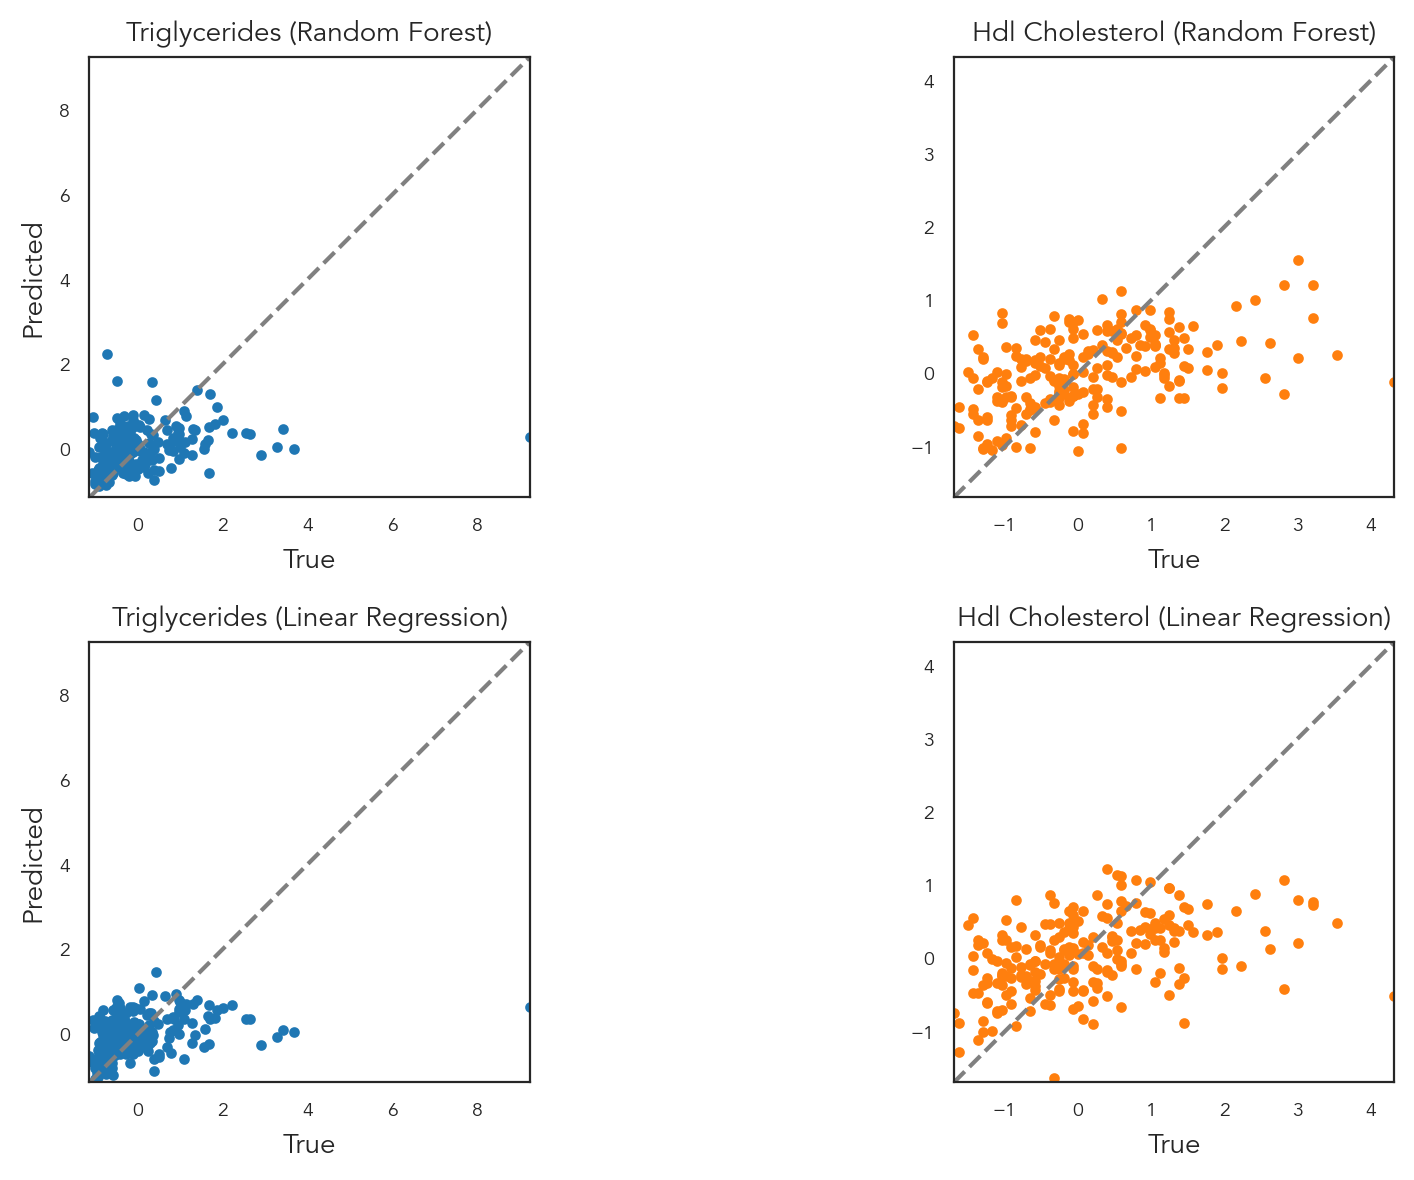

In [11]:
# Diagnostic Plots (baseline intercomparison)

fig, axes = plt.subplots(2, 2, figsize=(10, 6))
for i, col in enumerate(target_cols):
    color = target_colors[col]  # get EDA-consistent color
    for j, (pred_vals, title) in enumerate(zip(
        [y_pred_rf[:, i], y_pred_linear[:, i]],
        ["Random Forest", "Linear Regression"]
    )):
        ax = axes[j, i]
        true_vals = y_test_scaled[col]
        min_val = min(true_vals.min(), pred_vals.min())
        max_val = max(true_vals.max(), pred_vals.max())

        ax.scatter(true_vals, pred_vals, alpha=1, s=8, color=color)
        ax.plot([min_val, max_val], [min_val, max_val], '--', color='gray')
        ax.set_title(f"{col.replace('_', ' ').title()} ({title})", fontsize=8, fontproperties=avenir_font)
        ax.set_xlabel("True", fontproperties=avenir_font)
        if i == 0:
            ax.set_ylabel("Predicted", fontproperties=avenir_font)
        else:
            ax.set_ylabel("")
        ax.set_xlim(min_val, max_val)
        ax.set_ylim(min_val, max_val)
        ax.set_aspect('equal', 'box')

        ax.tick_params(axis='both', labelsize=6)
        for tick in ax.get_xticklabels() + ax.get_yticklabels():
            tick.set_fontproperties(avenir_font_small)

plt.tight_layout()
plt.show()


In [12]:
# Compute Metrics

summary = []

models = {
    "Random Forest": rf_model,
    "Linear Regression": linear_model
}

for model_name, model_pipeline in models.items():
    # Predict on train and test
    y_train_pred = model_pipeline.predict(X_train)
    y_test_pred = model_pipeline.predict(X_test)

    for i, target in enumerate(target_cols):
        train_r2 = r2_score(y_train_scaled[target], y_train_pred[:, i])
        test_r2 = r2_score(y_test_scaled[target], y_test_pred[:, i])
        train_rmse = mean_squared_error(y_train_scaled[target], y_train_pred[:, i], squared=False)
        test_rmse = mean_squared_error(y_test_scaled[target], y_test_pred[:, i], squared=False)

        summary.append({
            "Baseline Model": model_name,
            "Target": target.replace('_', ' ').title(),
            "Train R²": round(train_r2, 3),
            "Test R²": round(test_r2, 3),
            "Train RMSE": round(train_rmse, 3),
            "Test RMSE": round(test_rmse, 3)
        })

# === Display metrics as DataFrame ===
metrics_df = pd.DataFrame(summary)
display(metrics_df)

,Baseline Model,Target,Train R²,Test R²,Train RMSE,Test RMSE
0,Random Forest,Triglycerides,0.875,0.078,0.353,1.041
1,Random Forest,Hdl Cholesterol,0.884,0.219,0.341,0.981
2,Linear Regression,Triglycerides,0.224,0.119,0.881,1.018
3,Linear Regression,Hdl Cholesterol,0.238,0.168,0.873,1.012


In [13]:
# Ensure model directory exists
os.makedirs("../models", exist_ok=True)

# Save test/train splits for 1-to-1 comparison
y_train_scaled.reset_index(drop=True).to_feather("../data/processed/y_train_scaled.feather")
y_test_scaled.reset_index(drop=True).to_feather("../data/processed/y_test_scaled.feather")
X_train.reset_index(drop=True).to_feather("../data/processed/X_train.feather")
X_test.reset_index(drop=True).to_feather("../data/processed/X_test.feather")


# Save baseline models
joblib.dump(rf_model, "../models/baseline_rf_model.pkl")
joblib.dump(linear_model, "../models/baseline_linear_model.pkl")

# Save preprocessing pipeline
joblib.dump(preprocessor, "../models/preprocessor.pkl")
joblib.dump(target_scaler, "../models/target_scaler.pkl")

# Save metadata (feature/target schema)
metadata = {
    "target_cols": target_cols,
    "cat_features": cat_features,
    "num_features": num_features
}
with open("../models/model_metadata.json", "w") as f:
    json.dump(metadata, f)

print("✅ Saved:")
print("  • Random Forest model to     ../models/baseline_rf_model.pkl")
print("  • Linear Regression model to ../models/baseline_linear_model.pkl")
print("  • Preprocessor to            ../models/preprocessor.pkl")
print("  • Target scaler to           ../models/target_scaler.pkl")
print("  • Metadata to                ../models/model_metadata.json")


✅ Saved:
  • Random Forest model to     ../models/baseline_rf_model.pkl
  • Linear Regression model to ../models/baseline_linear_model.pkl
  • Preprocessor to            ../models/preprocessor.pkl
  • Target scaler to           ../models/target_scaler.pkl
  • Metadata to                ../models/model_metadata.json
